## Содержание:
1. [Постановка задачи](#Постановка-задачи)
2. [Способ решения](#Способ-решения)
3. [Отбор признаков: гипотеза](#Отбор-признаков:-гипотеза)
4. [Отбор признаков: эксперименты](#Отбор-признаков:-эксперименты)
5. [Выводы](#Выводы)

### Постановка задачи

Имеется <a href=https://archive.ics.uci.edu/ml/datasets/airfoil+self-noise>набор данных от NASA</a>, описывающий поведение аэродинамических поверхностей разных размеров в аэродинамической трубе при различных скоростях и углах атаки. Положение наблюдателя (датчиков) было одинаково во время всех экспериментов.

<b>Задача:</b>

На имеющемся наборе данных научиться предсказывать уровень звукого давления (Scaled sound pressure level) в зависимости от различных конфигураций аэродинамической трубы.

<b>Входные данные:</b> 
* Frequency, in Hertzs. 
* Angle of attack, in degrees. 
* Chord length, in meters. 
* Free-stream velocity, in meters per second. 
* Suction side displacement thickness, in meters. 

<b>Выходные данные:</b>
* Scaled sound pressure level, in decibels.

### Способ решения:

Будем решать задачу с помощью линейной регрессии. 

Обобзначим $n$ за размер обучающей выборки, $m$ за количество признаков.<br>
Пусть $Y$ - столбец размера $n$, состоящий из откликов обучающей выборки.<br>
Пусть $X$ - матрица размера $n \times m$, состоящая из входных данных обучающей выборки.

Линейная регрессия имеет следующий вид:
$$ Y = X \theta + \varepsilon $$

В качестве метрики рассмотрим MSE:
$$ MSE = \frac{1}{n} \sum\limits_{i = 1}^{n} \left(Y_i-\hat{Y}_i\right)^2 $$

Тогда решение находится аналитически:
$$ \hat{\theta} = (X^\top X)^{-1} X^\top Y$$

### Отбор признаков: гипотеза

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from math import inf

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

Загрузим данные, разобъём на обучающую и тестовую выборки:

In [3]:
data = pd.read_csv('airfoil_self_noise.dat', delimiter='\t')
number_of_features = data.shape[-1] - 1

Посмотрим, как отклик зависит от каждой переменной:

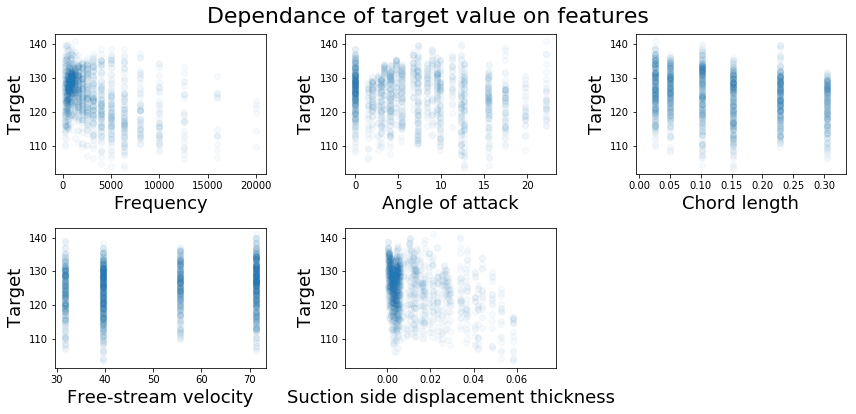

In [4]:
plt.figure(figsize=(12, 6))
plt.suptitle('Dependance of target value on features', fontsize=22)

for feature in range(number_of_features):
    plt.subplot(2, 3, feature + 1)
    plt.ylabel('Target', fontsize=18)
    plt.xlabel(data.columns[feature], fontsize=18)
    plt.scatter(data.iloc[:, feature], data.iloc[:, -1], alpha=0.03)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Обучим линеную модель, посмотрим резюме:

In [5]:
X = data.iloc[:, :-1]
X = sm.add_constant(X)
Y = data.iloc[:, -1]

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                       
=====================================================================================================
Dep. Variable:     Scaled sound pressure level, in decibels    R-squared:                       0.516
Model:                                                   OLS   Adj. R-squared:                  0.514
Method:                                        Least Squares   F-statistic:                     318.8
Date:                                       Wed, 20 Feb 2019   Prob (F-statistic):          1.15e-232
Time:                                               20:44:01   Log-Likelihood:                -4490.1
No. Observations:                                       1503   AIC:                             8992.
Df Residuals:                                           1497   BIC:                             9024.
Df Model:                                                  5                                         
Covariance Type:                                   nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 132.8338      0.545    243.866      0.000     131.765     133.902
Frequency                              -0.0013   4.21e-05    -30.452      0.000      -0.001      -0.001
Angle of attack                        -0.4219      0.039    -10.847      0.000      -0.498      -0.346
Chord length                          -35.6880      1.630    -21.889      0.000     -38.886     -32.490
Free-stream velocity                    0.0999      0.008     12.279      0.000       0.084       0.116
Suction side displacement thickness  -147.3005     15.015     -9.810      0.000    -176.753    -117.848
==============================================================================
Omnibus:                       12.947   Durbin-Watson:                   0.447
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               19.228
Skew:                          -0.020   Prob(JB):                     6.68e-05
Kurtosis:                       3.553   Cond. No.                     5.18e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Смотрим на таблицу, замечаем следующее:
* Prob (F-statistic): 1.15e-232 $\Longrightarrow$ гипотеза о незначимости регресси отвергается;
* Для каждого признака p-value (P>|t|) гипотезы о незначимости признаков отвергаются для всех признаков.

**Гипотеза**:

Необходимо оставить все признаки для получения оптимальной модели.

### Отбор признаков: эксперименты

Разобъём выборку случайным образом на обучующую и тестовую части. Будем перебирать всевозможные подмножества признаков, обучаться и смотреть ошибку на тестовых данных. Для фиксированного количества признаков будем выбирать такое подмножество, на котором ошибка минимальна.

In [6]:
# в этих массивах храним среднее/дисперсию ошибки на трэйн/тесте
# в зависимости от количества признаков
ols_train_mean_list = []
ols_test_mean_list  = []
ols_train_std_list  = []
ols_test_std_list   = []

# количество бутстрепных итераций по разбиениями на трэйн/тест
bootstrap_iter = 100

In [7]:
# фиксируем количество признаков
for features_cnt in range(1, data.shape[-1]):
    
    # генерируем всевозможные комбинации признаков в заданном количестве
    features_subsets = itertools.combinations(np.arange(data.shape[-1] - 1), features_cnt)
    
    # информация о лучшей модели для текущего количества признаков
    best_ols_train_mean = inf
    best_ols_test_mean  = inf
    best_ols_train_std  = inf
    best_ols_test_std   = inf

    # фиксируем признаки
    for features in features_subsets:
        ols_train_list = []
        ols_test_list  = []
        
        # делаем бутстреп по разбиенияем на тестовую/обучающую выборки
        for it in range(bootstrap_iter):
            train, test = train_test_split(data)
            
            # оставляем в обучающей выборке только интересующие нас признаки
            train_current = train[train.columns[np.array(features)]]

            # оставляем в тестовой выборке только интересующие нас признаки
            test_current = test[test.columns[np.array(features)]]

            # обучаем модель
            model = LinearRegression(n_jobs=4)
            model.fit(train_current, train.iloc[:,-1])

            # предсказания модели
            predicted_train = model.predict(train_current)
            predicted_test  = model.predict(test_current)

            # ошибка на трэйне/тесте
            ols_train_current = mean_squared_error(predicted_train, train.iloc[:,-1])
            ols_test_current  = mean_squared_error(predicted_test,  test.iloc[:,-1])
            ols_train_list.append(ols_train_current)
            ols_test_list.append(ols_test_current)
        
        # mean и std ошибок
        ols_train_mean = np.mean(ols_train_list)
        ols_test_mean  = np.mean(ols_test_list)
        ols_train_std  = np.std(ols_train_list)
        ols_test_std   = np.std(ols_test_list)
        
        # сравниваем с лучшей моделью
        if ols_test_mean < best_ols_test_mean:
            best_ols_train_mean = ols_train_mean 
            best_ols_test_mean  = ols_test_mean
            best_ols_train_std = ols_train_std
            best_ols_test_std  = ols_test_std
    
    # сохраняем информацию о лучшей моделе
    ols_train_mean_list.append(best_ols_train_mean)
    ols_test_mean_list.append(best_ols_test_mean)
    ols_train_std_list.append(best_ols_train_std)
    ols_test_std_list.append(best_ols_test_std)

Изображаем посчитанную информацию на графике:

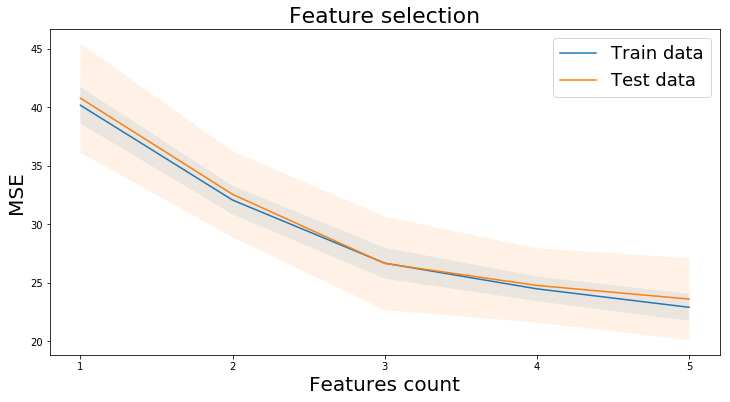

In [8]:
ols_train_mean_list = np.array(ols_train_mean_list)
ols_test_mean_list  = np.array(ols_test_mean_list)
ols_train_std_list  = np.array(ols_train_std_list)
ols_test_std_list   = np.array(ols_test_std_list)
grid = np.arange(1, data.shape[-1])

plt.figure(figsize=(12, 6))
plt.title('Feature selection', fontsize=22)
plt.xlabel('Features count', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(grid)

plt.plot(grid, ols_train_mean_list, label='Train data')
plt.fill_between(grid,
                 ols_train_mean_list - 1.96 * ols_train_std_list,
                 ols_train_mean_list + 1.96 * ols_train_std_list, alpha=0.1)

plt.plot(grid, ols_test_mean_list, label='Test data')
plt.fill_between(grid,
                 ols_test_mean_list - 1.96 * ols_test_std_list,
                 ols_test_mean_list + 1.96 * ols_test_std_list, alpha=0.1)

plt.legend(fontsize=18)
plt.show()

### Выводы
* Признаков настолько мало, что модель является сильно простой, что не приводит к переобучению. Это заметно из того, что ошибка монотонно убывает;
* Для получения хорошей модели стоит оставить все имеющиеся признаки.